# 1. Check GPU Status

In [1]:
import subprocess

#!nvidia-smi -i 0 -e 0
nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(nvidiasmi_output)
nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(nvidiasmi_ecc_note)

Wed May 11 15:07:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:19:00.0 Off |                  N/A |
| 32%   44C    P0    61W / 250W |      1MiB / 11019MiB |     19%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   40C    P8     1W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

# 2. Set Up

In [2]:
#@title 1.2 Prepare Folders
import subprocess, os, sys
import pathlib, shutil

from utils.utils_os import *
from main import do_run

# the following paths are same as preprocessing.py
root_path = os.getcwd()
initDirPath = f'{root_path}/outputs/init_images'
outDirPath = f'{root_path}/outputs/images_out'
model_path = f'{root_path}/outputs/models'

# project directory
PROJECT_DIR = os.path.abspath(os.getcwd())
sys.path.append(PROJECT_DIR)
os.chdir(f'{PROJECT_DIR}')

In [17]:
# import all dependencies

### preprocess: download absent packages
preprocess(model_path, PROJECT_DIR)


import torch
import pandas as pd
import gc
import io
import math
import timm
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
from types import SimpleNamespace
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
from resize_right import resize
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Output
import hashlib
from functools import partial  
from IPython.display import Image as ipyimg
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
from infer import InferenceHelper


from CLIP import clip




import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# If running locally, there's a good chance your env will need this in order to not crash upon np.matmul() or similar operations.
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# AdaBins stuff
MAX_ADABINS_AREA = 500000

# CUDA Device
DEVICE = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')
print('Using device:', DEVICE)
device = DEVICE # At least one of the modules expects this name..


if torch.cuda.get_device_capability(DEVICE) == (8,0): ## A100 fix thanks to Emad
    print('Disabling CUDNN for A100 gpu', file=sys.stderr)
    torch.backends.cudnn.enabled = False

Using device: cuda:0


# 3. Diffusion and CLIP model settings

In [8]:
#@markdown ####**Models Settings:**
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100"]
use_secondary_model = True #@param {type: 'boolean'}
diffusion_sampling_mode = 'ddim' #@param ['plms','ddim']  


use_checkpoint = True #@param {type: 'boolean'}
ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

def download_models(diffusion_model,use_secondary_model,fallback=False):
  model_256_downloaded = False
  model_512_downloaded = False
  model_secondary_downloaded = False

  model_256_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'
  model_512_SHA = '9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648'
  model_secondary_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'

  model_256_link = 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'
  model_512_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/512x512_diffusion_uncond_finetune_008100.pt'
  model_secondary_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/secondary_model_imagenet_2.pth'

  model_256_link_fb = 'https://www.dropbox.com/s/9tqnqo930mpnpcn/256x256_diffusion_uncond.pt'
  model_512_link_fb = 'https://huggingface.co/lowlevelware/512x512_diffusion_unconditional_ImageNet/resolve/main/512x512_diffusion_uncond_finetune_008100.pt'
  model_secondary_link_fb = 'https://the-eye.eu/public/AI/models/v-diffusion/secondary_model_imagenet_2.pth'

  model_256_path = f'{model_path}/256x256_diffusion_uncond.pt'
  model_512_path = f'{model_path}/512x512_diffusion_uncond_finetune_008100.pt'
  model_secondary_path = f'{model_path}/secondary_model_imagenet_2.pth'

  if fallback:
    model_256_link = model_256_link_fb
    model_512_link = model_512_link_fb
    model_secondary_link = model_secondary_link_fb
  # Download the diffusion model
  if diffusion_model == '256x256_diffusion_uncond':
    if os.path.exists(model_256_path) and check_model_SHA:
      print('Checking 256 Diffusion File')
      with open(model_256_path,"rb") as f:
          bytes = f.read() 
          hash = hashlib.sha256(bytes).hexdigest();
      if hash == model_256_SHA:
        print('256 Model SHA matches')
        model_256_downloaded = True
      else: 
        print("256 Model SHA doesn't match, redownloading...")
        wget(model_256_link, model_path)
        if os.path.exists(model_256_path):
          model_256_downloaded = True
        else:
          print('First URL Failed using FallBack')
          download_models(diffusion_model,use_secondary_model,True)
    elif os.path.exists(model_256_path) and not check_model_SHA or model_256_downloaded == True:
      print('256 Model already downloaded, check check_model_SHA if the file is corrupt')
    else:  
      wget(model_256_link, model_path)
      if os.path.exists(model_256_path):
        model_256_downloaded = True
      else:
        print('First URL Failed using FallBack')
        download_models(diffusion_model,True)
  elif diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    if os.path.exists(model_512_path) and check_model_SHA:
      print('Checking 512 Diffusion File')
      with open(model_512_path,"rb") as f:
          bytes = f.read() 
          hash = hashlib.sha256(bytes).hexdigest();
      if hash == model_512_SHA:
        print('512 Model SHA matches')
        if os.path.exists(model_512_path):
          model_512_downloaded = True
        else:
          print('First URL Failed using FallBack')
          download_models(diffusion_model,use_secondary_model,True)
      else:  
        print("512 Model SHA doesn't match, redownloading...")
        wget(model_512_link, model_path)
        if os.path.exists(model_512_path):
          model_512_downloaded = True
        else:
          print('First URL Failed using FallBack')
          download_models(diffusion_model,use_secondary_model,True)
    elif os.path.exists(model_512_path) and not check_model_SHA or model_512_downloaded == True:
      print('512 Model already downloaded, check check_model_SHA if the file is corrupt')
    else:  
      wget(model_512_link, model_path)
      model_512_downloaded = True
  # Download the secondary diffusion model v2
  if use_secondary_model == True:
    if os.path.exists(model_secondary_path) and check_model_SHA:
      print('Checking Secondary Diffusion File')
      with open(model_secondary_path,"rb") as f:
          bytes = f.read() 
          hash = hashlib.sha256(bytes).hexdigest();
      if hash == model_secondary_SHA:
        print('Secondary Model SHA matches')
        model_secondary_downloaded = True
      else:  
        print("Secondary Model SHA doesn't match, redownloading...")
        wget(model_secondary_link, model_path)
        if os.path.exists(model_secondary_path):
          model_secondary_downloaded = True
        else:
          print('First URL Failed using FallBack')
          download_models(diffusion_model,use_secondary_model,True)
    elif os.path.exists(model_secondary_path) and not check_model_SHA or model_secondary_downloaded == True:
      print('Secondary Model already downloaded, check check_model_SHA if the file is corrupt')
    else:  
      wget(model_secondary_link, model_path)
      if os.path.exists(model_secondary_path):
          model_secondary_downloaded = True
      else:
        print('First URL Failed using FallBack')
        download_models(diffusion_model,use_secondary_model,True)

download_models(diffusion_model,use_secondary_model)

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

model_default = model_config['image_size']



if use_secondary_model:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
    secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32 is True: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)) 
if ViTB16 is True: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device) ) 
if ViTL14 is True: clip_models.append(clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device) ) 
if RN50 is True: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4 is True: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN50x16 is True: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN50x64 is True: clip_models.append(clip.load('RN50x64', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN101 is True: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device)) 

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

512 Model already downloaded, check check_model_SHA if the file is corrupt
Secondary Model already downloaded, check check_model_SHA if the file is corrupt
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/kaihua/anaconda3/envs/disco_diffusion/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# 4. Settings

In [9]:
#@markdown ####**Basic Settings:**
batch_name = 'TimeToDisco2' #@param{type: 'string'}
steps = 250 #@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
width_height = [768, 1280]#@param{type: 'raw'}
clip_guidance_scale = 5000 #@param{type: 'number'}
tv_scale =  0#@param{type: 'number'}
range_scale =   150#@param{type: 'number'}
sat_scale =   0#@param{type: 'number'}
cutn_batches = 4  #@param{type: 'number'}
skip_augs = False#@param{type: 'boolean'}

#@markdown ---

#@markdown ####**Init Settings:**
init_image = None #@param{type: 'string'}
init_scale = 1000 #@param{type: 'integer'}
skip_steps = 10 #@param{type: 'integer'}
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{batch_name}'
createPath(batchFolder)

### Animation Settings

In [10]:
#@markdown ####**Animation Mode:**
animation_mode = 'None' #@param ['None', '2D', '3D', 'Video Input'] {type:'string'}
#@markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


#@markdown ---

#@markdown ####**Video Input Settings:**
video_init_path = "training.mp4" #@param {type: 'string'}
extract_nth_frame = 2 #@param {type: 'number'}
video_init_seed_continuity = True #@param {type: 'boolean'}

if animation_mode == "Video Input":
  videoFramesFolder = f'videoFrames'
  createPath(videoFramesFolder)
  print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
  try:
    for f in pathlib.Path(f'{videoFramesFolder}').glob('*.jpg'):
      f.unlink()
  except:
    print('')
  vf = f'select=not(mod(n\,{extract_nth_frame}))'
  subprocess.run(['ffmpeg', '-i', f'{video_init_path}', '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', '-loglevel', 'error', '-stats', f'{videoFramesFolder}/%04d.jpg'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


#@markdown ---

#@markdown ####**2D Animation Settings:**
#@markdown `zoom` is a multiplier of dimensions, 1 is no zoom.
#@markdown All rotations are provided in degrees.

key_frames = True #@param {type:"boolean"}
max_frames = 10000#@param {type:"number"}

if animation_mode == "Video Input":
  max_frames = len(glob(f'{videoFramesFolder}/*.jpg'))

interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0:(0)"#@param {type:"string"}
zoom = "0: (1), 10: (1.05)"#@param {type:"string"}
translation_x = "0: (0)"#@param {type:"string"}
translation_y = "0: (0)"#@param {type:"string"}
translation_z = "0: (10.0)"#@param {type:"string"}
rotation_3d_x = "0: (0)"#@param {type:"string"}
rotation_3d_y = "0: (0)"#@param {type:"string"}
rotation_3d_z = "0: (0)"#@param {type:"string"}
midas_depth_model = "dpt_large"#@param {type:"string"}
midas_weight = 0.3#@param {type:"number"}
near_plane = 200#@param {type:"number"}
far_plane = 10000#@param {type:"number"}
fov = 40#@param {type:"number"}
padding_mode = 'border'#@param {type:"string"}
sampling_mode = 'bicubic'#@param {type:"string"}

#======= TURBO MODE
#@markdown ---
#@markdown ####**Turbo Mode (3D anim only):**
#@markdown (Starts after frame 10,) skips diffusion steps and just uses depth map to warp images for skipped frames.
#@markdown Speeds up rendering by 2x-4x, and may improve image coherence between frames. frame_blend_mode smooths abrupt texture changes across 2 frames.
#@markdown For different settings tuned for Turbo Mode, refer to the original Disco-Turbo Github: https://github.com/zippy731/disco-diffusion-turbo

turbo_mode = False #@param {type:"boolean"}
turbo_steps = "3" #@param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10 # frames

#insist turbo be used only w 3d anim.
if turbo_mode and animation_mode != '3D':
  print('=====')
  print('Turbo mode only available with 3D animations. Disabling Turbo.')
  print('=====')
  turbo_mode = False

#@markdown ---

#@markdown ####**Coherency Settings:**
#@markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 1500 #@param{type: 'integer'}
#@markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = '60%' #@param ['40%', '50%', '60%', '70%', '80%'] {type: 'string'}

#======= VR MODE
#@markdown ---
#@markdown ####**VR Mode (3D anim only):**
#@markdown Enables stereo rendering of left/right eye views (supporting Turbo) which use a different (fish-eye) camera projection matrix.   
#@markdown Note the images you're prompting will work better if they have some inherent wide-angle aspect
#@markdown The generated images will need to be combined into left/right videos. These can then be stitched into the VR180 format.
#@markdown Google made the VR180 Creator tool but subsequently stopped supporting it. It's available for download in a few places including https://www.patrickgrunwald.de/vr180-creator-download
#@markdown The tool is not only good for stitching (videos and photos) but also for adding the correct metadata into existing videos, which is needed for services like YouTube to identify the format correctly.
#@markdown Watching YouTube VR videos isn't necessarily the easiest depending on your headset. For instance Oculus have a dedicated media studio and store which makes the files easier to access on a Quest https://creator.oculus.com/manage/mediastudio/
#@markdown 
#@markdown The command to get ffmpeg to concat your frames for each eye is in the form: `ffmpeg -framerate 15 -i frame_%4d_l.png l.mp4` (repeat for r)

vr_mode = False #@param {type:"boolean"}
#@markdown `vr_eye_angle` is the y-axis rotation of the eyes towards the center
vr_eye_angle = 0.5 #@param{type:"number"}
#@markdown interpupillary distance (between the eyes)
vr_ipd = 5.0 #@param{type:"number"}

#insist VR be used only w 3d anim.
if vr_mode and animation_mode != '3D':
  print('=====')
  print('VR mode only available with 3D animations. Disabling VR.')
  print('=====')
  vr_mode = False


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.
    
    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.
    
    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.
    
    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.
    
    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    
    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'
    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
      
    
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_prompts(prompts):
  prompt_series = pd.Series([np.nan for a in range(max_frames)])
  for i, prompt in prompts.items():
    prompt_series[i] = prompt
  # prompt_series = prompt_series.astype(str)
  prompt_series = prompt_series.ffill().bfill()
  return prompt_series

if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_z` correctly for key frames.\n"
            "Attempting to interpret `translation_z` as "
            f'"0: ({translation_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_z = f"0: ({translation_z})"
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))

    try:
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_x` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_x` as "
            f'"0: ({rotation_3d_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_x = f"0: ({rotation_3d_x})"
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

    try:
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_y` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_y` as "
            f'"0: ({rotation_3d_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_y = f"0: ({rotation_3d_y})"
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

    try:
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_z` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_z` as "
            f'"0: ({rotation_3d_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_z = f"0: ({rotation_3d_z})"
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    translation_z = float(translation_z)
    rotation_3d_x = float(rotation_3d_x)
    rotation_3d_y = float(rotation_3d_y)
    rotation_3d_z = float(rotation_3d_z)

### Extra Settings
 Partial Saves, Advanced Settings, Cutn Scheduling

In [11]:
#@markdown ####**Saving:**

intermediate_saves = 10#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}
#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps 

#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.

#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)


if type(intermediate_saves) is not list:
  if intermediate_saves:
    steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
  else:
    steps_per_checkpoint = steps+10
else:
  steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
  partialFolder = f'{batchFolder}/partials'
  createPath(partialFolder)

  #@markdown ---

#@markdown ####**Advanced Settings:**
#@markdown *There are a few extra advanced settings available if you double click this cell.*

#@markdown *Perlin init will replace your init, so uncheck if using one.*

perlin_init = False  #@param{type: 'boolean'}
perlin_mode = 'mixed' #@param ['mixed', 'color', 'gray']
set_seed = 'random_seed' #@param{type: 'string'}
eta = 0.8#@param{type: 'number'}
clamp_grad = True #@param{type: 'boolean'}
clamp_max = 0.05 #@param{type: 'number'}


### EXTRA ADVANCED SETTINGS:
randomize_class = True
clip_denoised = False
fuzzy_prompt = False
rand_mag = 0.05


 #@markdown ---

#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000

#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.

cut_overview = "[12]*400+[4]*600" #@param {type: 'string'}       
cut_innercut ="[4]*400+[12]*600"#@param {type: 'string'}  
cut_ic_pow = 1#@param {type: 'number'}  
cut_icgray_p = "[0.2]*400+[0]*600"#@param {type: 'string'}

Will save every 21 steps


### Prompts
`animation_mode: None` will only use the first set. `animation_mode: 2D / Video` will run through them per the set frames and hold on the last one.

In [12]:
text_prompts = {
    0: ["A beautiful painting of a singular lighthouse, shining its light across a dense forest by greg rutkowski and thomas kinkade, Trending on artstation.:2", "a girl and a boy sit around a camp fire under the stars.:2", "blue color scheme:1"],
    100: ["This set of prompts start at frame 100","This prompt has weight five:5"],
}

In [13]:
image_prompts = {
    # 0:['ImagePromptsWorkButArentVeryGood.png:2',],
}

# 4. Diffuse!

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

  0%|          | 0/240 [00:00<?, ?it/s]

Seed used: 2532599944


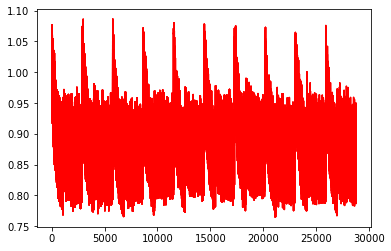

In [14]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =  25 #@param{type: 'number'}
n_batches =  10 #@param{type: 'number'}

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1 

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = 'latest' #@param{type: 'string'}
resume_from_frame = 'latest' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
  else:
    start_frame = int(resume_from_frame)+1
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'translation_z_series':translation_z_series,
    'rotation_3d_x_series':rotation_3d_x_series,
    'rotation_3d_y_series':rotation_3d_y_series,
    'rotation_3d_z_series':rotation_3d_z_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run(args, model_path, gpu_device=DEVICE)
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create the video

In [18]:
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = False #@param {type: 'boolean'}

if skip_video_for_run_all == True:
  print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')

else:
  # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  latest_run = batchNum

  folder = batch_name #@param
  run = latest_run #@param
  final_frame = 'final_frame'


  init_frame = 1#@param {type:"number"} This is the frame where the video will start
  last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 12#@param {type:"number"}
  # view_video_in_cell = True #@param {type: 'boolean'}

  frames = []
  # tqdm.write('Generating video...')

  if last_frame == 'final_frame':
    last_frame = len(glob(batchFolder+f"/{folder}({run})_*.png"))
    print(f'Total frames: {last_frame}')

  image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
  filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready and saved to the images folder")

  # if view_video_in_cell:
  #     mp4 = open(filepath,'rb').read()
  #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')
  

Total frames: 10
b"ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)\n  configuration: --prefix=/home/kaihua/anaconda3 --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame\n  libavutil      56. 51.100 / 56. 51.100\n  libavcodec     58. 91.100 / 58. 91.100\n  libavformat    58. 45.100 / 58. 45.100\n  libavdevice    58. 10.100 / 58. 10.100\n  libavfilter     7. 85.100 /  7. 85.100\n  libavresample   4.  0.  0 /  4.  0.  0\n  libswscale      5.  7.100 /  5.  7.100\n  libswresample   3.  7.100 /  3.  7.100\nUnrecognized option 'crf'.\nError splitting the argument list: Option not found\n"


RuntimeError: b"ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)\n  configuration: --prefix=/home/kaihua/anaconda3 --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame\n  libavutil      56. 51.100 / 56. 51.100\n  libavcodec     58. 91.100 / 58. 91.100\n  libavformat    58. 45.100 / 58. 45.100\n  libavdevice    58. 10.100 / 58. 10.100\n  libavfilter     7. 85.100 /  7. 85.100\n  libavresample   4.  0.  0 /  4.  0.  0\n  libswscale      5.  7.100 /  5.  7.100\n  libswresample   3.  7.100 /  3.  7.100\nUnrecognized option 'crf'.\nError splitting the argument list: Option not found\n"